<a href="https://colab.research.google.com/github/karim-mammadov/CodeAlpha_Tasks/blob/main/Car_Price_Prediction_with_Machine_Learning_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload Kaggle API key and download dataset

In [39]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"karimmammadov1","key":"bd3f40fd258b68cf544b437535a12d7d"}'}

In [40]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [41]:
!kaggle datasets download -d vijayaadithyanvg/car-price-predictionused-cars

Dataset URL: https://www.kaggle.com/datasets/vijayaadithyanvg/car-price-predictionused-cars
License(s): CC0-1.0
car-price-predictionused-cars.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
import zipfile

with zipfile.ZipFile('/content/car-price-predictionused-cars.zip','r') as zip_ref:
    zip_ref.extractall('/content/car_price_data')

**Import Libraries**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
import zipfile
import os

In [46]:
df = pd.read_csv('/content/car_price_data/car data.csv')

In [47]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [48]:
#Initial data exploration
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nColumn Names:", df.columns)
df.info()

Dataset Shape: (301, 9)

Missing Values:
 Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64

Column Names: Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: floa

**Data cleaning**

In [49]:
df.rename(columns={
    'year': 'Year',
    'selling_price': 'SellingPrice',
    'km_driven': 'DrivenKms',
    'fuel': 'FuelType',
    'seller_type': 'SellerType',
    'transmission': 'Transmission',
    'owner': 'Owner'
}, inplace=True)

In [51]:
# Extract brand name
df['CarBrand'] = df['Car_Name'].apply(lambda x: x.split()[0])
df.drop('Car_Name', axis=1, inplace=True)

In [52]:
# Remove duplicates if any
df.drop_duplicates(inplace=True)

df.head()

,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,CarBrand
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,ritz
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,sx4
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,ciaz
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,wagon
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,swift


In [58]:
df.columns = [col.replace('_', '').strip() for col in df.columns]

**Feature Engineering**

In [53]:
# Create a new feature for car age
df['CarAge'] = 2025 - df['Year']

In [54]:
# Drop Year (we now have CarAge)
df.drop('Year', axis=1, inplace=True)

In [55]:
# Display basic stats
print(df.describe())

       Selling_Price  Present_Price     Driven_kms       Owner      CarAge
count     299.000000     299.000000     299.000000  299.000000  299.000000
mean        4.589632       7.541037   36916.752508    0.043478   11.384615
std         4.984240       8.566332   39015.170352    0.248720    2.896868
min         0.100000       0.320000     500.000000    0.000000    7.000000
25%         0.850000       1.200000   15000.000000    0.000000    9.000000
50%         3.510000       6.100000   32000.000000    0.000000   11.000000
75%         6.000000       9.840000   48883.500000    0.000000   13.000000
max        35.000000      92.600000  500000.000000    3.000000   22.000000


Data Visualization

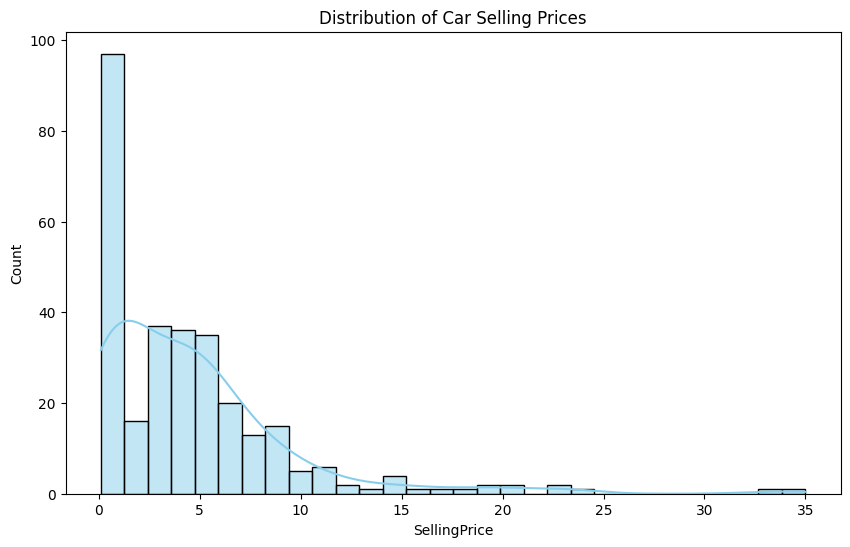

In [59]:
plt.figure(figsize=(10,6))
sns.histplot(df['SellingPrice'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Car Selling Prices")
plt.show()

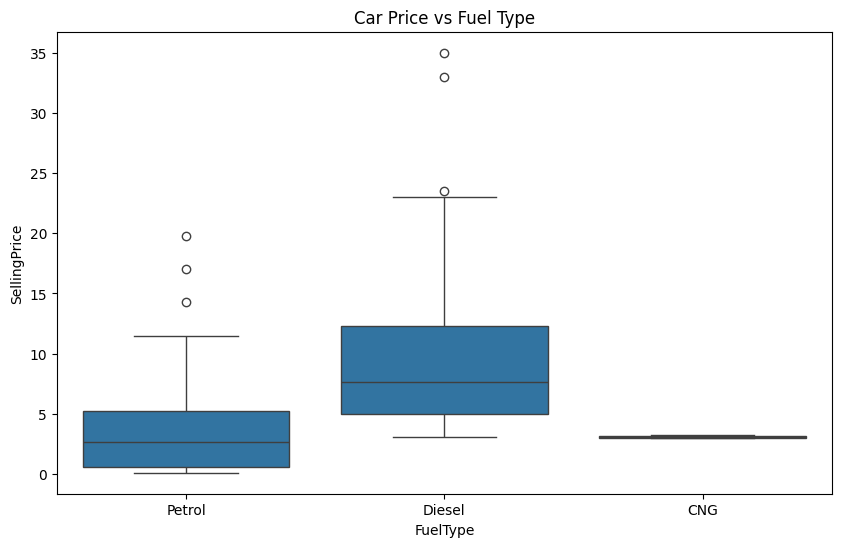

In [60]:
plt.figure(figsize=(10,6))
sns.boxplot(x='FuelType', y='SellingPrice', data=df)
plt.title("Car Price vs Fuel Type")
plt.show()

**Define features and target**

In [61]:
X = df.drop('SellingPrice', axis=1)
y = df['SellingPrice']

In [62]:
df.columns

Index(['SellingPrice', 'PresentPrice', 'Drivenkms', 'FuelType', 'Sellingtype',
       'Transmission', 'Owner', 'CarBrand', 'CarAge'],
      dtype='object')

In [75]:
# Identify categorical and numerical columns
numerical_features = ['CarAge', 'PresentPrice', 'Drivenkms']
categorical_features = ['FuelType', 'Sellingtype', 'Transmission', 'CarBrand']

**Data preprocessing using ColumnTransformer**

In [76]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Build pipeline with Gradient Boosting Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

In [79]:
# Hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)

✅ Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}


In [82]:
# Evaluate the best model
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")

✅ RMSE: 2.62
✅ R² Score: 0.73


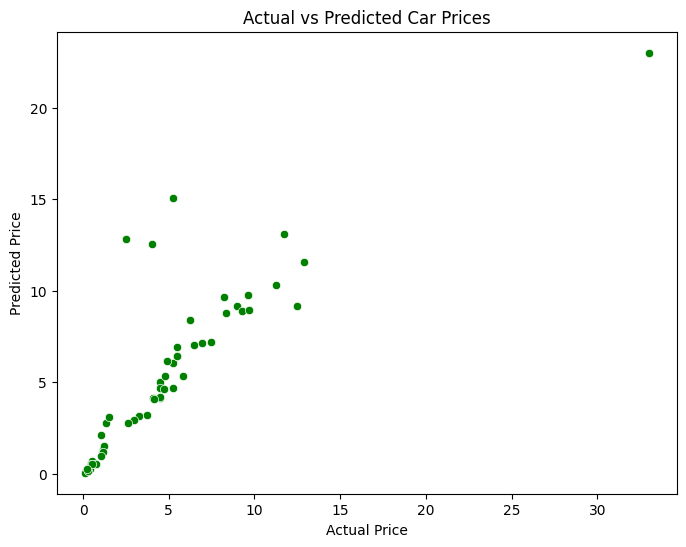

In [83]:
# Visualize actual vs predicted prices
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='green')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()

In [84]:
from sklearn.ensemble import RandomForestRegressor

# New Model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [85]:
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 15],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best Parameters
print("🌲 Best Parameters (Random Forest):", grid_search_rf.best_params_)

🌲 Best Parameters (Random Forest): {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


In [86]:
y_pred_rf = grid_search_rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"✅ Random Forest RMSE: {rf_rmse:.2f}")
print(f"✅ Random Forest R² Score: {rf_r2:.2f}")

✅ Random Forest RMSE: 3.32
✅ Random Forest R² Score: 0.57


In [87]:
!pip install xgboost

In [90]:
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

In [102]:
param_grid_xgb = {
    'regressor__n_estimators': [200, 300, 500],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)

Best Parameters (XGBoost): {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 0.8}


In [92]:
y_pred_xgb = grid_search_xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"✅ XGBoost RMSE: {xgb_rmse:.2f}")
print(f"✅ XGBoost R² Score: {xgb_r2:.2f}")

✅ XGBoost RMSE: 1.74
✅ XGBoost R² Score: 0.88


In [93]:
results = pd.DataFrame({
    'Model': ['Gradient Boosting', 'Random Forest', 'XGBoost'],
    'RMSE': [2.62, rf_rmse, xgb_rmse],
    'R² Score': [0.73, rf_r2, xgb_r2]
})
print(results)

               Model      RMSE  R² Score
0  Gradient Boosting  2.620000  0.730000
1      Random Forest  3.315349  0.573529
2            XGBoost  1.743920  0.882000


<Figure size 1000x600 with 0 Axes>

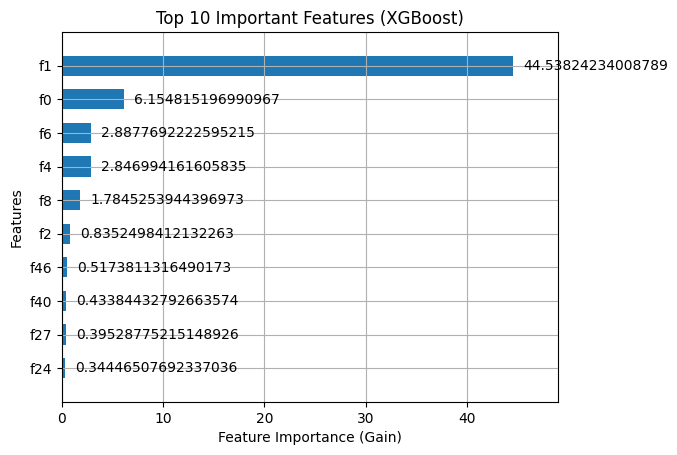

In [101]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb_reg = grid_search_xgb.best_estimator_.named_steps['regressor']

plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_reg, importance_type='gain', max_num_features=10, height=0.6)
plt.title("Top 10 Important Features (XGBoost)")
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.show();

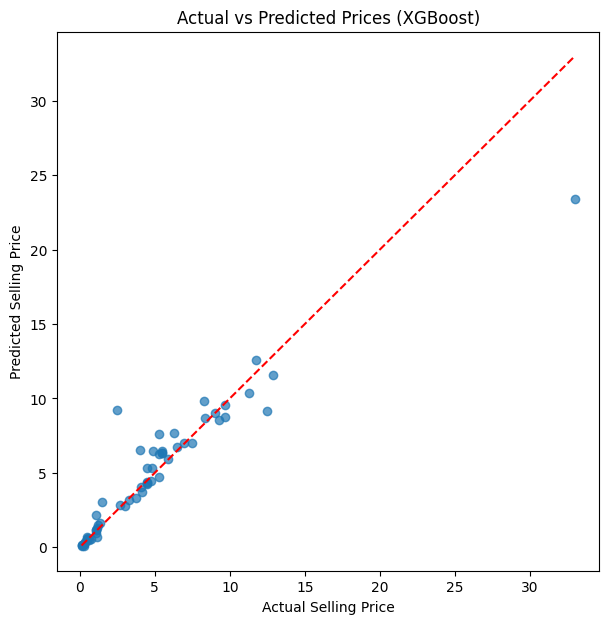

In [98]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_xgb, alpha=0.7)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Prices (XGBoost)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

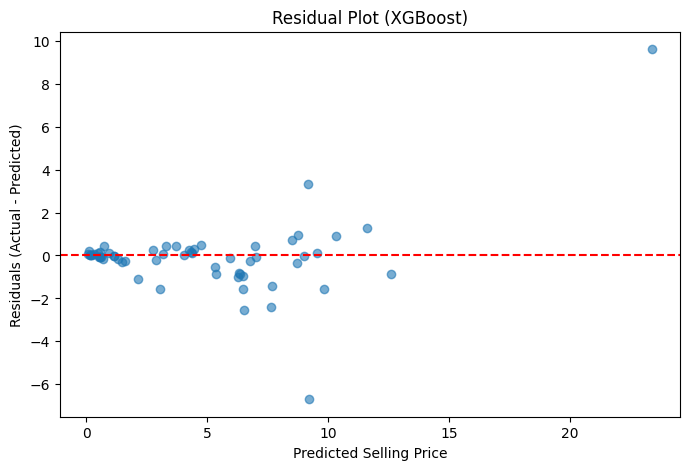

In [100]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(8,5))
plt.scatter(y_pred_xgb, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Selling Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (XGBoost)")
plt.show()

Project Summary: Car Price Prediction

In this project, we built a machine learning model to predict car prices based on features such as brand, year, mileage, fuel type, and transmission.

We performed data preprocessing, feature encoding, and model evaluation using Pandas, Scikit-learn, and Matplotlib.

Two regression models were trained — Random Forest Regressor and XGBoost Regressor.

After tuning and comparison, XGBoost achieved the best performance with:
✅ XGBoost RMSE: 1.74

✅ XGBoost R² Score: 0.88

This result demonstrates that XGBoost provides better accuracy and generalization for car price prediction.